In [ ]:
import numpy as np
import pandas as pd
import os
import librosa
import matplotlib.pyplot as plt
import time

# Imports for the new pipeline
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Lambda
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from skimage.transform import resize # For resizing spectrograms

from mealpy import SCA
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [ ]:
EMOTIONS = { 0 : 'Angry',
             1 : 'Fearful',
             2 : 'Happy',
             3 : 'Neutral',
             4 : 'Sad',
             5 : 'Surprised'
           }  
# !!! IMPORTANT: Update this path to your local dataset location !!!
# DATA_PATH = '/kaggle/input/eaed-voice/EAED' 
DATA_PATH = './Data' # Example local path
SAMPLE_RATE = 16000
DURATION = 3 # seconds
RESNET_INPUT_SHAPE = (224, 224, 3) # ResNet50 expects 3 channels

# 1. Data Loading and Initial Exploration

In [ ]:
file_names = []
file_emotions = []
file_paths = []

# Define mapping from filename code to full emotion name
emotion_code_map = {
    'ang': 'Angry',
    'hap': 'Happy',
    'neu': 'Neutral',
    'sad': 'Sad',
    # Add other codes if present (e.g., 'fea' for Fearful, 'sur' for Surprised)
}

# Iterate over each show folder (e.g., EYASE)
for show_folder in os.listdir(DATA_PATH):
    show_path = os.path.join(DATA_PATH, show_folder)
    if not os.path.isdir(show_path):
        continue
    
    # Iterate over actor folders (e.g., Female01, Male02)
    for actor_folder in os.listdir(show_path):
        actor_path = os.path.join(show_path, actor_folder)
        if not os.path.isdir(actor_path):
            continue
        
        # Iterate over audio files within the actor folder
        for audio_file in os.listdir(actor_path):
            if audio_file.endswith(".wav"):
                try:
                    # Parse information from the file name
                    # Example: fm01_ang (1).wav -> parts = ['fm01', 'ang (1).wav']
                    parts = audio_file.split("_", 1) 
                    if len(parts) < 2:
                        print(f"Skipping file with unexpected format: {audio_file}")
                        continue
                        
                    # Extract emotion code: 'ang (1).wav' -> 'ang'
                    emotion_code = parts[1].split(' ')[0]
                    
                    # Map code to full emotion name
                    emotion_full_name = emotion_code_map.get(emotion_code)
                    
                    
                        continue
                        
                    # Encode emotion using the EMOTIONS dictionary
                    emotion_encoded = list(EMOTIONS.keys())[list(EMOTIONS.values()).index(emotion_full_name)]
                    
                    # Construct the full file path
                    file_path = os.path.join(actor_path, audio_file)
                    
                    # Append the information to the lists
                    file_names.append(audio_file)
                    file_emotions.append(emotion_encoded)
                    file_paths.append(file_path)
                except Exception as e:
                    print(f"Error processing file {audio_file} in {actor_path}: {e}")

In [4]:
# Create a DataFrame
Data = pd.DataFrame({
    "Name": file_names,
    "Emotion": file_emotions,
    "Path": file_paths
})

In [5]:
Data.head()

,Name,Emotion,Path
0,LailaArabi_Fearful_5.wav,1,/kaggle/input/eaed-voice/EAED/SahebElSaada/Lai...
1,LailaArabi_Fearful_6.wav,1,/kaggle/input/eaed-voice/EAED/SahebElSaada/Lai...
2,LailaArabi_Fearful_3.wav,1,/kaggle/input/eaed-voice/EAED/SahebElSaada/Lai...
3,LailaArabi_Fearful_1.wav,1,/kaggle/input/eaed-voice/EAED/SahebElSaada/Lai...
4,LailaArabi_Fearful_2.wav,1,/kaggle/input/eaed-voice/EAED/SahebElSaada/Lai...


In [6]:
print("number of files is {}".format(len(Data)))

number of files is 3614


Text(0, 0.5, 'Number of examples')

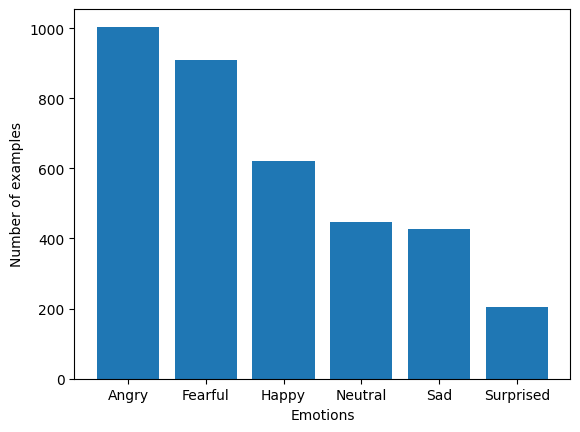

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.bar(x=range(6), height=Data['Emotion'].value_counts())
ax.set_xticks(ticks=range(6))
ax.set_xticklabels([EMOTIONS[i] for i in EMOTIONS ],fontsize=10)
ax.set_xlabel('Emotions')
ax.set_ylabel('Number of examples')

# 2. Spectrogram Generation

In [8]:
def getMELspectrogram(audio, sample_rate):
    mel_spec = librosa.feature.melspectrogram(y=audio,
                                              sr=sample_rate,
                                              n_fft=1024,
                                              win_length = 512,
                                              window='hamming',
                                              hop_length = 256,
                                              n_mels=128,
                                              fmax=sample_rate/2
                                             )
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    return mel_spec_db

MEL spectrogram shape:  (128, 188)


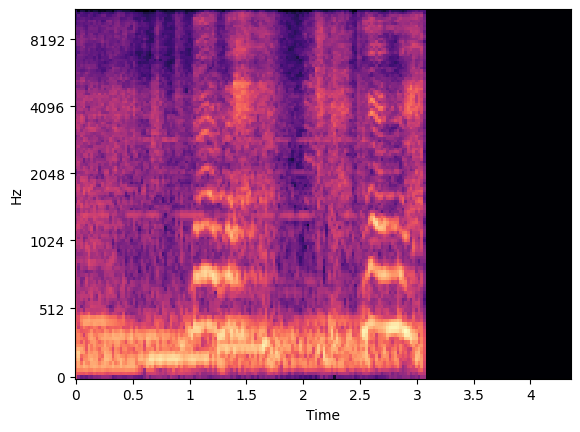

In [ ]:
audio, sample_rate = librosa.load(Data.loc[0,'Path'], duration=DURATION, offset=0.5,sr=SAMPLE_RATE)
signal = np.zeros((int(SAMPLE_RATE*DURATION,)))
signal[:len(audio)] = audio
mel_spectrogram = getMELspectrogram(signal, SAMPLE_RATE)
librosa.display.specshow(mel_spectrogram, sr=sample_rate, y_axis='mel', x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('MEL spectrogram example')
plt.tight_layout()
plt.show()
print('Original MEL spectrogram shape: ',mel_spectrogram.shape)

In [ ]:
# Function to resize and prepare spectrogram for ResNet50
def prepare_spectrogram_for_resnet(spec, output_shape):
    # Resize
    spec_resized = resize(spec, output_shape[:2], anti_aliasing=True)
    # Normalize to 0-1 range (assuming spec is in dB)
    spec_resized -= spec_resized.min()
    if spec_resized.max() > 0:
        spec_resized /= spec_resized.max()
    # Convert to 3 channels by stacking
    spec_3channel = np.stack([spec_resized]*3, axis=-1)
    return spec_3channel

In [ ]:
# Test preparation function
prepared_spec = prepare_spectrogram_for_resnet(mel_spectrogram, RESNET_INPUT_SHAPE)
print('Prepared spectrogram shape: ', prepared_spec.shape)
plt.imshow(prepared_spec)
plt.title('Prepared Spectrogram (3 channels)')
plt.show()

In [ ]:
prepared_spectrograms = []
start_time = time.time()
print("Generating and preparing spectrograms...")
for i, file_path in enumerate(Data.Path):
    try:
        audio, sample_rate = librosa.load(file_path, duration=DURATION, offset=0.5, sr=SAMPLE_RATE)
        signal = np.zeros((int(SAMPLE_RATE*DURATION,)))
        signal[:len(audio)] = audio
        mel_spectrogram = getMELspectrogram(signal, sample_rate=SAMPLE_RATE)
        prepared_spec = prepare_spectrogram_for_resnet(mel_spectrogram, RESNET_INPUT_SHAPE)
        prepared_spectrograms.append(prepared_spec)
    except Exception as e:
        print(f"\nError processing {file_path}: {e}")
        # Handle error, e.g., append a placeholder or remove the corresponding row from Data
        # For now, let's remove the row if processing fails
        Data = Data.drop(i).reset_index(drop=True) # Drop the row and reset index
        # Need to adjust the loop counter or iterate differently if dropping rows
        # A safer approach might be to collect valid indices and filter Data afterwards
        # Or store results in a dict {index: spec} and rebuild Data
        # For simplicity now, we just print error and continue, which might lead to mismatch
        # A better fix is needed for robust processing.
        pass # Continue to next file

    print(f"\r Processed {i+1}/{len(Data.Path)} files", end='')

prepared_spectrograms = np.array(prepared_spectrograms)
end_time = time.time()
print(f"\nFinished in {end_time - start_time:.2f} seconds.")
print("Shape of prepared spectrograms array:", prepared_spectrograms.shape)

 Processed 1495/3614 files

/tmp/ipykernel_34/1901792975.py:4: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(file_path, duration=3, offset=0.5, sr=SAMPLE_RATE)
/opt/conda/lib/python3.10/site-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


 Processed 3613/3614 files

# 3. Feature Extraction using ResNet50

In [ ]:
# Load pre-trained ResNet50 model + higher level layers
print("Loading ResNet50 model...")
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=RESNET_INPUT_SHAPE, pooling='avg')
# base_model.summary() # Optional: Print model summary

# Create a new model that outputs the features
feature_model = Model(inputs=base_model.input, outputs=base_model.output)
print("ResNet50 model loaded.")

In [ ]:
# Extract features
# Note: ResNet50 expects preprocessed input (specific normalization)
# We'll apply the standard ResNet preprocessing
print("Extracting features using ResNet50...")
start_time = time.time()
resnet_features = feature_model.predict(tf.keras.applications.resnet50.preprocess_input(prepared_spectrograms))
end_time = time.time()
print(f"Finished in {end_time - start_time:.2f} seconds.")
print("Shape of extracted features:", resnet_features.shape)

# Free up memory
del prepared_spectrograms
import gc
gc.collect()

# 4. Data Splitting and Scaling

In [ ]:
X = resnet_features
y = Data['Emotion'].values

# Split data into training+validation and testing sets (80% train+val, 20% test)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Split training+validation into training and validation sets (80% train, 20% val of the original 80%)
# This means 64% train, 16% val, 20% test of the total data
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42, stratify=y_train_val) # 0.2 * 0.8 = 0.16

print("Original data shape:", X.shape, y.shape)
print("Training data shape:", X_train.shape, y_train.shape)
print("Validation data shape:", X_val.shape, y_val.shape)
print("Test data shape:", X_test.shape, y_test.shape)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Free up memory
del X, y, X_train, X_val, X_test, X_train_val, y_train_val, resnet_features
gc.collect()

# 5. Feature Selection using Sine Cosine Algorithm (SCA)

In [ ]:
# Define the fitness function for SCA
num_features_total = X_train_scaled.shape[1]
knn_eval = KNeighborsClassifier(n_neighbors=5) # k-NN for evaluation within fitness function

def fitness_function(solution):
    selected_indices = np.where(solution == 1)[0]
    num_selected = len(selected_indices)

    if num_selected == 0:
        return 1.0 # Penalize solutions with no features

    # Select features
    X_train_subset = X_train_scaled[:, selected_indices]
    X_val_subset = X_val_scaled[:, selected_indices]

    # Train k-NN on the subset
    knn_eval.fit(X_train_subset, y_train)

    # Evaluate on validation set
    y_pred_val = knn_eval.predict(X_val_subset)
    accuracy = accuracy_score(y_val, y_pred_val)

    # Calculate fitness value (minimize this)
    fitness = 0.99 * (1 - accuracy) + 0.01 * (num_selected / num_features_total)
    return fitness

In [ ]:
# SCA Parameters
epoch = 20 # Number of iterations (reduce for quicker testing)
pop_size = 10 # Population size (reduce for quicker testing)
problem_dict = {
    "fit_func": fitness_function,
    "lb": 0, # Lower bound for each variable (feature selection = 0 or 1)
    "ub": 1,
    "minmax": "min",
    "log_to": None, # No logging
    "n_dims": num_features_total, # Number of features
    "verbose": True,
    # Define problem as binary
    "problem_type": "binary" # Important for feature selection
}

# Initialize and run SCA
print("Running Sine Cosine Algorithm for feature selection...")
start_time = time.time()
model_sca = SCA.OriginalSCA(epoch=epoch, pop_size=pop_size)
best_solution, best_fitness = model_sca.solve(problem_dict)
end_time = time.time()
print(f"SCA finished in {end_time - start_time:.2f} seconds.")

# Get selected features
selected_feature_indices = np.where(best_solution == 1)[0]
num_selected_features = len(selected_feature_indices)
print(f"Selected {num_selected_features} features out of {num_features_total}.")
print(f"Best fitness found: {best_fitness:.4f}")

# 6. Classification using k-NN with Selected Features

In [ ]:
# Select the features chosen by SCA
X_train_selected = X_train_scaled[:, selected_feature_indices]
X_test_selected = X_test_scaled[:, selected_feature_indices]

print("Training k-NN classifier on selected features...")
start_time = time.time()
knn_final = KNeighborsClassifier(n_neighbors=5) # You might want to tune n_neighbors
knn_final.fit(X_train_selected, y_train)
end_time = time.time()
print(f"k-NN training finished in {end_time - start_time:.2f} seconds.")

# Predict on the test set
print("Predicting on test set...")
start_time = time.time()
y_pred_test = knn_final.predict(X_test_selected)
end_time = time.time()
print(f"Prediction finished in {end_time - start_time:.2f} seconds.")

# 7. Evaluation and Visualization

In [ ]:
# Calculate metrics
accuracy_test = accuracy_score(y_test, y_pred_test)
f1_test = f1_score(y_test, y_pred_test, average='weighted') # Use 'weighted' for multiclass imbalance
conf_matrix = confusion_matrix(y_test, y_pred_test)
class_report = classification_report(y_test, y_pred_test, target_names=[EMOTIONS[i] for i in sorted(EMOTIONS.keys())])

print(f"\n--- Evaluation Results ---")
print(f"Test Accuracy: {accuracy_test:.4f}")
print(f"Test F1-Score (Weighted): {f1_test:.4f}")
print("\nClassification Report:")
print(class_report)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=[EMOTIONS[i] for i in sorted(EMOTIONS.keys())],
            yticklabels=[EMOTIONS[i] for i in sorted(EMOTIONS.keys())])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# --- End of New Pipeline ---

--- (Original Kaggle Notebook Code Below - Can be removed) ---

In [ ]:
# Original Augmentation Code (Not used in the new pipeline above)
# def addAWGN(signal, num_bits=16, augmented_num=2, snr_low=15, snr_high=30): 
#     ...
#     return signal + K.T * noise

In [ ]:
# Original Augmentation Application (Not used)
# for i,signal in enumerate(signals):
#     ...
#     print("\r Processed {}/{} files".format(i,len(signals)),end='')

 Processed 3613/3614 files

In [ ]:
# Original Model Imports (Not used)
# import torch
# import torch.nn as nn

In [ ]:
# Original ParallelModel Definition (Not used)
# class ParallelModel(nn.Module):
#     ...
#     return output_logits, output_softmax

In [ ]:
# Original Loss Function (Not used)
# def loss_fnc(predictions, targets):
#     return nn.CrossEntropyLoss()(input=predictions,target=targets)

In [ ]:
# Original Training Step (Not used)
# def make_train_step(model, loss_fnc, optimizer):
#     ...
#     return train_step

In [ ]:
# Original Validation Function (Not used)
# def make_validate_fnc(model,loss_fnc):
#     ...
#     return validate

In [ ]:
# Original Data Stacking (Handled differently now)
# X = np.stack(mel_spectrograms,axis=0)
# ...
# del signals

Shape of data:  (10842, 1, 128, 188)


In [ ]:
# Original Data Splitting (Handled differently now)
# train_ind,test_ind,val_ind = [],[],[]
# ...
# del X







X_train:(8671, 1, 128, 188), Y_train:(8671,)
X_val:(1083, 1, 128, 188), Y_val:(1083,)
X_test:(1088, 1, 128, 188), Y_test:(1088,)
Number of unique indexes is 10842, out of 10842


In [ ]:
# Original Scaling (Handled differently now)
# from sklearn.preprocessing import StandardScaler
# ...
# X_val = np.reshape(X_val, newshape=(b,c,h,w))

In [ ]:
# Original Training Loop (Not used)
# EPOCHS=150
# ...
# print(f"Epoch {epoch} --> loss:{epoch_loss:.4f}, acc:{epoch_acc:.2f}%, val_loss:{val_loss:.4f}, val_acc:{val_acc:.2f}%")

Selected device is cuda


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Number of trainable params:  393382
 Epoch 0: iteration 269/270
Epoch 0 --> loss:1.5898, acc:37.90%, val_loss:1.7054, val_acc:31.12%
 Epoch 1: iteration 269/270
Epoch 1 --> loss:1.4725, acc:43.09%, val_loss:1.5584, val_acc:36.84%
 Epoch 2: iteration 269/270
Epoch 2 --> loss:1.4243, acc:45.74%, val_loss:1.5954, val_acc:39.61%
 Epoch 3: iteration 269/270
Epoch 3 --> loss:1.4014, acc:46.36%, val_loss:1.4079, val_acc:47.46%
 Epoch 4: iteration 269/270
Epoch 4 --> loss:1.3678, acc:47.99%, val_loss:1.7297, val_acc:36.38%
 Epoch 5: iteration 269/270
Epoch 5 --> loss:1.3351, acc:48.82%, val_loss:1.4858, val_acc:42.20%
 Epoch 6: iteration 269/270
Epoch 6 --> loss:1.3246, acc:49.34%, val_loss:1.6047, val_acc:37.86%
 Epoch 7: iteration 269/270
Epoch 7 --> loss:1.2889, acc:50.96%, val_loss:1.4684, val_acc:44.32%
 Epoch 8: iteration 269/270
Epoch 8 --> loss:1.2725, acc:51.40%, val_loss:1.3028, val_acc:50.51%
 Epoch 9: iteration 269/270
Epoch 9 --> loss:1.2521, acc:52.53%, val_loss:1.5641, val_acc:4

In [ ]:
# Original Test Evaluation (Handled differently now)
# X_test_tensor = torch.tensor(X_test,device=device).float()
# ...
# print(f'Test accuracy is {test_acc:.2f}%')

Test loss is 0.325
Test accuracy is 89.43%


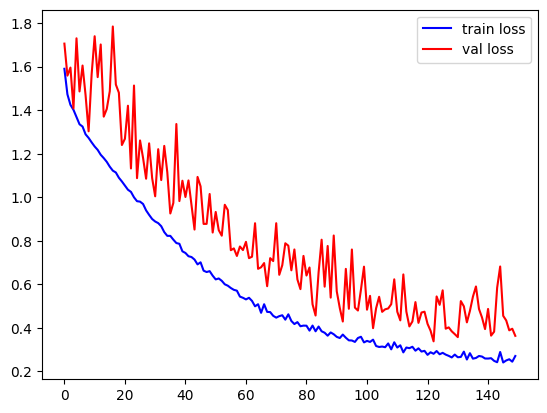

In [ ]:
# Original Loss Plot (Not applicable)
# plt.plot(losses,'b')
# plt.plot(val_losses,'r')
# plt.legend(['train loss','val loss'])